<a href="https://colab.research.google.com/github/FrederikBornemann/SyReAL/blob/main/notebooks/PySR_scoring_14_09_22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup


## Instructions
1. Work on a copy of this notebook: _File_ > _Save a copy in Drive_ (you will need a Google account).
2. (Optional) If you would like to do the deep learning component of this tutorial, turn on the GPU with Edit->Notebook settings->Hardware accelerator->GPU
3. Execute the following cell (click on it and press Ctrl+Enter) to install Julia, IJulia and other packages (if needed, update `JULIA_VERSION` and the other parameters). This takes a couple of minutes.
4. Continue to the next section.

_Notes_:
* If your Colab Runtime gets reset (e.g., due to inactivity), repeat steps 3, 4.
* After installation, if you want to change the Julia version or activate/deactivate the GPU, you will need to reset the Runtime: _Runtime_ > _Delete and disconnect runtime_ and repeat steps 2-4.

**Run the following code to install Julia**

In [ ]:
%%shell
set -e

#---------------------------------------------------#
JULIA_VERSION="1.7.2"
JULIA_PACKAGES="PyCall SymbolicRegression"
JULIA_NUM_THREADS=4
#---------------------------------------------------#

if [ -z `which julia` ]; then
  # Install Julia
  JULIA_VER=`cut -d '.' -f -2 <<< "$JULIA_VERSION"`
  echo "Installing Julia $JULIA_VERSION on the current Colab Runtime..."
  BASE_URL="https://julialang-s3.julialang.org/bin/linux/x64"
  URL="$BASE_URL/$JULIA_VER/julia-$JULIA_VERSION-linux-x86_64.tar.gz"
  wget -nv $URL -O /tmp/julia.tar.gz # -nv means "not verbose"
  tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
  rm /tmp/julia.tar.gz

  for PKG in `echo $JULIA_PACKAGES`; do
    echo "Installing Julia package $PKG..."
    julia -e 'using Pkg; pkg"add '$PKG'; precompile;"'
  done
  
  julia -e 'println("Success")'
fi

Install PySR and PyTorch-Lightning:

In [ ]:
%pip install -Uq pysr pytorch_lightning

     |████████████████████████████████| 58 kB 3.8 MB/s 
     |████████████████████████████████| 706 kB 16.4 MB/s 
     |████████████████████████████████| 67 kB 6.0 MB/s 
     |████████████████████████████████| 5.9 MB 53.9 MB/s 
     |████████████████████████████████| 419 kB 60.0 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.2+zzzcolab20220719082949 requires tensorboard<2.9,>=2.8, but you have tensorboard 2.10.0 which is incompatible.


The following step is not normally required, but colab's printing is non-standard and we need to manually set it up PyJulia:


In [ ]:
from julia import Julia

julia = Julia(compiled_modules=False)
from julia import Main
from julia.tools import redirect_output_streams

redirect_output_streams()


Let's install the backend of PySR, and all required libraries. We will also precompile them so they are faster at startup.

**(This may take some time)**

In [ ]:
import pysr

pysr.install()


In [ ]:
from sympy import *
from sympy import lambdify
from sympy import symbols
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from pysr import PySRRegressor
from google.colab import files
import seaborn as sns

In [ ]:
!sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended

In [ ]:
# enable latex text
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ['Tahoma', 'DejaVu Sans',
                               'Lucida Grande', 'Verdana'],
    "font.size": 14})

# Scoring with noise

In [ ]:
np.random.seed(0)

N = 100
xstart = 0
xstop = 2
upper_sigma = 2

def true_function(X, eps):
    try: 
        X = X[:,0]
    except:
        pass
    return 5 * np.cos(3.5 * X) - 1.3 + eps

X = (xstop-xstart) * np.random.rand(N, 5) + xstart      # produces X from xstart to xstop
sigma = np.random.rand(N) * (upper_sigma - 0.1) + 0.1
eps = sigma * np.random.randn(N)
y = true_function(X, eps)

In [ ]:
model = PySRRegressor(
    niterations=20,
    populations=20,
    binary_operators=["plus", "mult"],
    unary_operators=["cos"],
    denoise=True,
    model_selection='best',
    select_k_features=1
)
model.fit(X, y)

/usr/local/lib/python3.7/dist-packages/pysr/sr.py:1216: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  "Note: it looks like you are running in Jupyter. "


Using features ['x0']


/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


Started!

Cycles per second: 2.600e+04
Head worker occupation: 1.1%
Progress: 72 / 400 total iterations (18.000%)
Hall of Fame:
-----------------------------------------
Complexity  Loss       Score     Equation
1           1.155e+01  8.245e-08  -1.3352503
3           1.133e+01  9.563e-03  (x0 + -1.6267903)
4           9.734e+00  1.522e-01  (cos(x0) * -2.8547673)
6           8.267e+00  8.169e-02  ((cos(x0) * -2.2770438) * x0)
7           7.129e+00  1.480e-01  (((x0 * x0) + -3.1795855) * x0)
8           1.702e+00  1.432e+00  (cos((x0 + x0) * 1.7497073) * 5.0208964)
10          1.552e-04  4.651e+00  ((cos((x0 + x0) * 1.7497073) * 5.0044374) + -1.3045996)
12          1.552e-04  5.335e-06  ((cos((x0 + x0) + (x0 * 1.4994233)) + -0.260692) * 5.0044417)
16          1.425e-04  2.132e-02  ((cos(((x0 + (x0 + (x0 * 0.50180155))) + -0.0025882765) + x0) + -0.26130214) * 5.0043516)
19          1.385e-04  9.576e-03  ((cos((x0 + x0) * 1.7497073) * (5.0044374 + (cos(-1.7301764 * (x0 + x0)) * -0.0035042

PySRRegressor.equations_ = [
	    pick     score                                           equation  \
	0         0.000000                                         -1.3352503   
	1         0.028613                                  (-2.3938003 + x0)   
	2         0.175206                                cos(x0 * 3.4708436)   
	3         0.850137                  (cos(x0 * -3.4468582) * 5.023544)   
	4   >>>>  4.642567   ((cos(x0 * -3.499411) * 5.0045104) + -1.3045663)   
	5         0.000018  ((cos((x0 + x0) * 1.7497073) * 5.0044374) + -1...   
	6         0.004629  ((cos(((x0 + -0.00013003882) + x0) * 1.7497073...   
	7         0.038010  ((cos((((x0 * 1.5017745) + x0) + -0.0025625373...   
	8         0.000010  ((cos(((x0 + (x0 + (x0 * 0.50180155))) + -0.00...   
	9         0.000008  ((cos(((x0 + (x0 * 0.5018067)) + 0.059423488) ...   
	10        0.147372  ((cos((x0 + x0) * 1.7497073) * (5.0044374 + (-...   
	
	         loss  complexity  
	0   11.552940           1  
	1   10.910363         

## Plot all equations


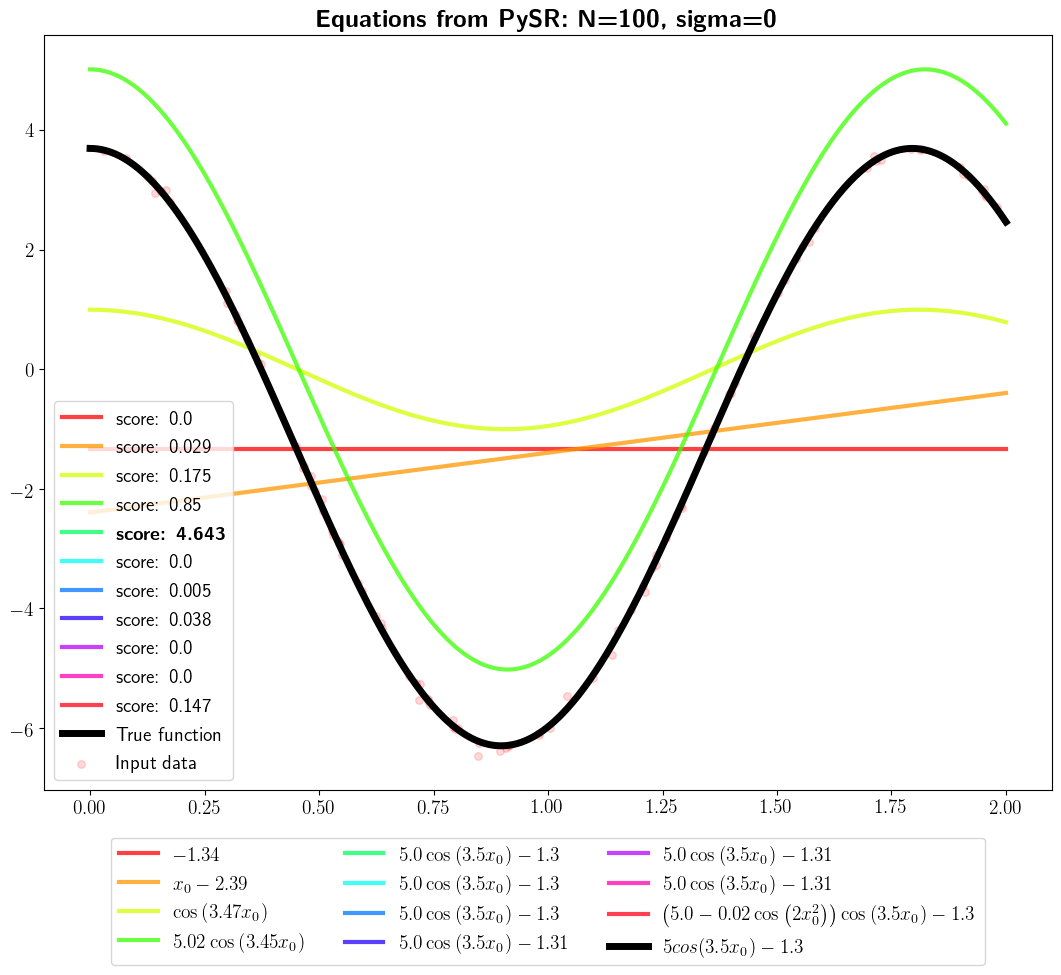

In [ ]:
plt.figure(figsize=(13, 10), dpi= 100, facecolor='w', edgecolor='k')

# plot input points
plt.scatter(X[:,0], y, s=30, label="Input data", alpha=0.15, color="red")

# get number of equations
idx = len(model.equations_)

palette = cm.get_cmap('hsv', idx)

# plot every equation from the model
eq_list = []
lines = []
x_con = np.linspace(xstart,xstop,500)

for i, eq in enumerate(model.sympy(range(idx))):
    # if best score => bold label
    preamble, endamble = ["", ""]
    if i == model.equations_.score.idxmax():
        preamble, endamble = ["\\textbf{", "}"]
    try:
        x0 = symbols('x0')
        lam_x = lambdify(x0, eq, modules=['numpy'])
        y_con = lam_x(x_con)
        line, = plt.plot(x_con, y_con, linewidth=3, label=f"{preamble}score: {round(model.equations_.score.iloc[i],3)}{endamble}", alpha=0.75, color=palette(i))
        lines.append(line)
    except:
        # some equations don't have a variable x0 and therefore are constants
        line, = plt.plot(x_con, np.full(x_con.shape, eq), alpha=0.75, color=palette(i),linewidth=3, label=f"{preamble}score: {round(model.equations_.score.iloc[i],3)}{endamble}")
        lines.append(line)
    
    # round parameters for legend
    for a in preorder_traversal(model.sympy(i)):
        if isinstance(a, Float):
            eq = eq.subs(a, round(a, 2))
    eq_list.append(f"${latex(eq)}$")

# plot true function
y_con = 5 * np.cos(3.5 * x_con) - 1.3
line, = plt.plot(x_con, y_con, linewidth=5, color="black", label="True function")
lines.append(line)
eq_list.append("$5cos(3.5x_0) - 1.3$")

legend1 = plt.legend(lines, eq_list, bbox_to_anchor=(0.5, -0.05), loc='upper center', ncol=3, fancybox=True)
plt.gca().add_artist(legend1)

plt.title(f"\\textbf{{Equations from PySR: N={N}, sigma={upper_sigma}}}", fontsize=18)
plt.legend(loc=3)
fig = plt.gcf()
plt.draw()
plt.show()

In [ ]:
filename = f"all_equations_N{N}_s{upper_sigma}.png"
fig.savefig(filename, dpi=150, bbox_inches='tight')
files.download(filename) 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

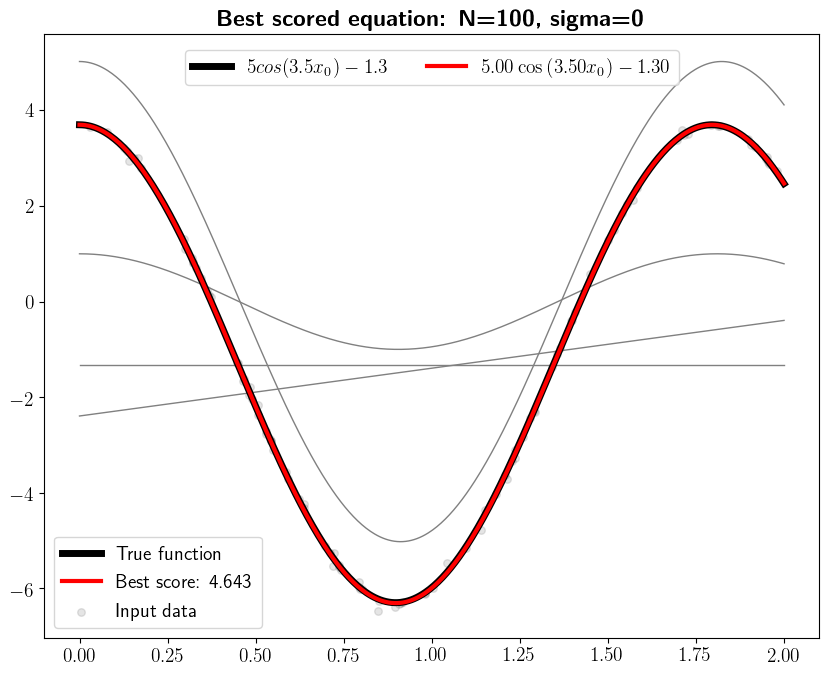

In [ ]:
plt.figure(figsize=(10, 8), dpi= 100, facecolor='w', edgecolor='k')

# plot input points
plt.scatter(X[:,0], y, s=30, label="Input data", alpha=0.1, color="black")


x_con = np.linspace(xstart,xstop,500)
for i, eq in enumerate(model.sympy(range(idx))):
    if i == model.equations_.score.idxmax():
        continue
    try:
        x0 = symbols('x0')
        lam_x = lambdify(x0, eq, modules=['numpy'])
        y_con = lam_x(x_con)

        plt.plot(x_con, y_con, linewidth=1, alpha=1, color="grey")
    except:
        # some equations don't have a variable x0 and therefore are constants
        plt.plot(x_con, np.full(x_con.shape, eq), alpha=1, color="grey", linewidth=1)
        continue

# plot true function
y_con = 5 * np.cos(3.5 * x_con) - 1.3
true_line, = plt.plot(x_con, y_con, linewidth=5, color="black", label="True function", alpha=1)

# plot equation with highest score seperately (for the color)
x0 = symbols('x0')
lam_x = lambdify(x0, model.sympy(model.equations_.score.idxmax()), modules=['numpy'])
y_con = lam_x(x_con)
best_line, = plt.plot(x_con, y_con, linewidth=3, label=f"Best score: {round(model.equations_.score.iloc[model.equations_.score.idxmax()],3)}", alpha=1, color="red")

legend1 = plt.legend([true_line, best_line], [r"$5cos(3.5x_0)-1.3$", f"${model.latex(model.equations_.score.idxmax())}$"], bbox_to_anchor=(0.5, 0.99), loc='upper center', ncol=2, fancybox=True)
plt.gca().add_artist(legend1)

plt.title(f"\\textbf{{Best scored equation: N={N}, sigma={upper_sigma}}}")
plt.legend(loc="lower left")
fig = plt.gcf()
plt.draw()
plt.show()

In [ ]:
filename = f"best_equation_N{N}_s{upper_sigma}.png"
fig.savefig(filename, dpi=150, bbox_inches='tight')
files.download(filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Plot the difference

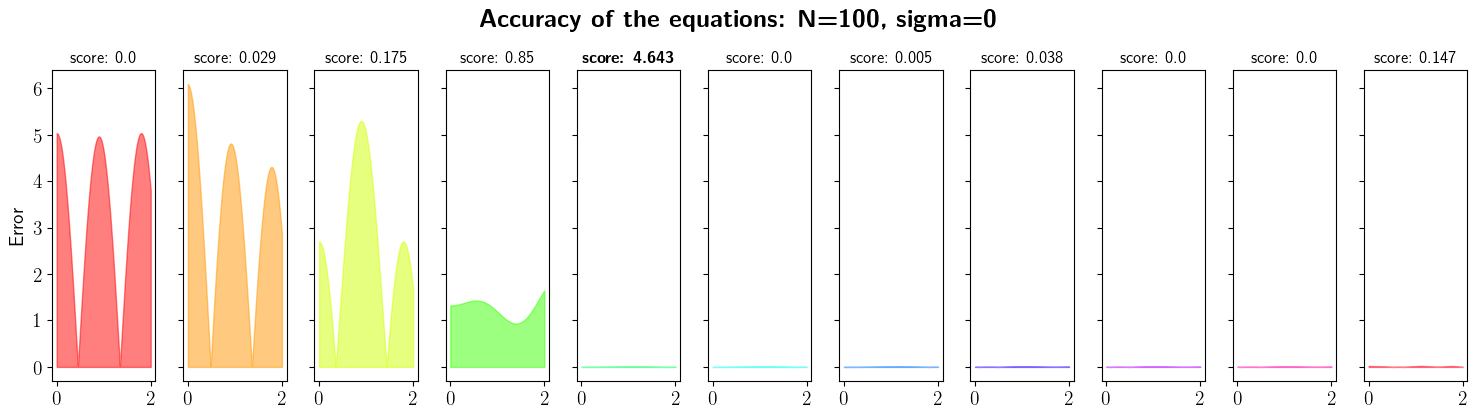

In [ ]:
rows = 1
columns = len(model.equations_)

fig, ax = plt.subplots(rows, columns, sharex=True, sharey=True, figsize=(15,4), dpi= 100, facecolor='w', edgecolor='k')

x_con = np.linspace(xstart,xstop,500)
y_con_true = true_function(x_con,0)
for i, eq in enumerate(model.sympy(range(idx))):
    preamble, endamble = ["", ""]
    if i == model.equations_.score.idxmax():
        preamble, endamble = ["\\textbf{", "}"]
    try:
        x0 = symbols('x0')
        lam_x = lambdify(x0, eq, modules=['numpy'])
        y_con = lam_x(x_con)

        ax[i].fill_between(x_con, np.abs(y_con-y_con_true), linewidth=1, alpha=0.5, color=palette(i), label=f"loss: {round(model.equations_.loss.iloc[i],3)}")
        ax[i].set_title(f"{preamble}score: {round(model.equations_.score.iloc[i],3)}{endamble}", fontsize=12)
    except:
        # some equations don't have a variable x0 and therefore are constants
        ax[i].fill_between(x_con, np.abs(np.full(x_con.shape, eq)-y_con_true), alpha=0.5, color=palette(i), linewidth=1, label=f"loss: {round(model.equations_.loss.iloc[i],3)}")
        continue
    # ax[i].legend(loc="upper center")

fig.suptitle(f"\\textbf{{Accuracy of the equations: N={N}, sigma={upper_sigma}}}", fontsize=18, y=1.05)
ax[0].set_ylabel("Error")
fig.tight_layout()
plt.show()

In [ ]:
filename = f"equation_errors_N{N}_s{upper_sigma}.png"
fig.savefig(filename, dpi=150, bbox_inches='tight')
files.download(filename) 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Pareto-front

In [ ]:
# make list of all equation's losses and complexities
losses = -np.log(model.equations_.loss)
complexities = model.equations_.complexity

# a way too complex way of making the pareto front curve ...
X_pareto = np.arange(0, complexities.max()+1)
Y = []
temp = losses[0]
m = 0
for x in X_pareto :
    Break = False
    for i in range(len(complexities))[m:]:
        if complexities[i] == x:
            Y.append(losses[i])
            temp = losses[i]
            m = i
            Break = True
            break
    if not Break:
        Y.append(temp)

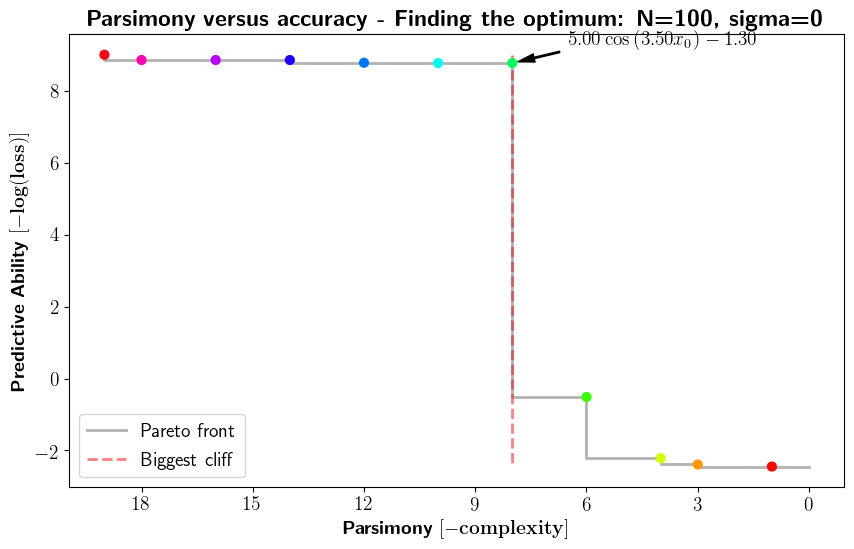

In [ ]:
# colors in list from previous graph 
color_list = [x for x in palette(range(idx))]

# plot pareto front
plt.figure(figsize=(10, 6), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(X_pareto ,Y, drawstyle='steps-post', linewidth=2, zorder=1, color="black", alpha=0.3, label="Pareto front")
highest_score_idx = model.equations_.score.idxmax()
plt.vlines(complexities[highest_score_idx], losses.max(), losses.min(), color="red", zorder=2, linewidth=2, linestyles='dashed', alpha=0.5, label="Biggest cliff")
plt.scatter(complexities,losses, color=color_list, zorder=3, s=40)

# text and arrow
plt.annotate(
f'${model.latex(highest_score_idx)}$', weight='bold', fontsize=14,
xy=(complexities[highest_score_idx], losses[highest_score_idx]),
xytext=(complexities[highest_score_idx]-1.5, losses[highest_score_idx]+0.5),
arrowprops=dict(facecolor='black', edgecolor="black", shrink=0.1, headwidth=6, width=1))

# set the xlimits to be the reverse of the current xlimits
ax = plt.gca()
ax.set_xlim(ax.get_xlim()[::-1])
ax.xaxis.set_major_locator(MaxNLocator(integer=True, nbins=10))

plt.ylabel(r"\textbf{Predictive Ability} $\mathbf{[-log(loss)]}$")
plt.xlabel(r"\textbf{Parsimony} $\mathbf{[-complexity]}$")
plt.title(f"\\textbf{{Parsimony versus accuracy - Finding the optimum: N={N}, sigma={upper_sigma}}}")

plt.legend(loc=3)
fig = plt.gcf()
plt.draw()
plt.show()

In [ ]:
filename = f"pareto_front_N{N}_s{upper_sigma}.png"
fig.savefig(filename, dpi=150, bbox_inches='tight')
files.download(filename)  

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>